**Step 1: Install & Import Libraries**

In [1]:
# Install Kaggle API (if not already installed)
!pip install kaggle

In [2]:
# Import libraries
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

**Step 2: Upload Kaggle API Key & Download Dataset**

Upload kaggle.json to Colab

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samidiprarthana","key":"575bf96b134f0c66cfeaeb20d24fbca1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Install Kaggle API

In [5]:
!pip install kaggle


Download the dataset

In [6]:
!kaggle datasets download -d uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka


Dataset URL: https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka
License(s): MIT
 87% 836M/960M [00:07<00:02, 54.2MB/s]
100% 960M/960M [00:07<00:00, 136MB/s] 


Unzip the dataset

In [7]:
!unzip common-diseases-of-tea-leaves-in-sri-lanka.zip -d tea_leaf_dataset


Archive:  common-diseases-of-tea-leaves-in-sri-lanka.zip
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_1 - Copy.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_1.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_10.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_11.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_12.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_13.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_14.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_15.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_16.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_17.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_18.jpg  
  inflating: t

Verify the Dataset

In [8]:
import os

data_dir = 'tea_leaf_dataset'
print(os.listdir(data_dir))  # Should list disease class folders


['Algal Leaf', 'White Spot', 'Red Leaf Spot', 'Bird Eye Spot', 'Anthracnose', 'Gray Light', 'Brown Blight', 'Healthy']


**Step 3: Visualize Dataset**

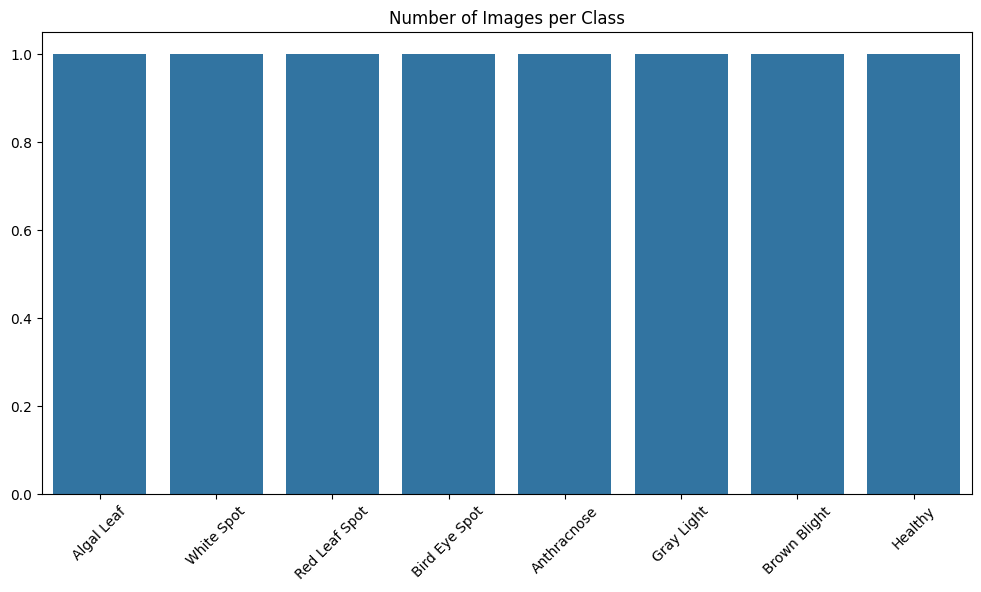

In [9]:
data_dir = 'tea_leaf_dataset'
classes = os.listdir(data_dir)

# Count images per class
counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.show()


**Step 4: Data Preprocessing & Augmentation**

In [34]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

#Training data with augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 960 images belonging to 8 classes.
Found 236 images belonging to 8 classes.


In [35]:
num_classes = len(train_generator.class_indices)
print("Classes:", train_generator.class_indices)
print("Train samples:", train_generator.samples, "Validation samples:", validation_generator.samples)



Classes: {'Algal Leaf': 0, 'Anthracnose': 1, 'Bird Eye Spot': 2, 'Brown Blight': 3, 'Gray Light': 4, 'Healthy': 5, 'Red Leaf Spot': 6, 'White Spot': 7}
Train samples: 960 Validation samples: 236


**Step 5: Build ResNet50 Model**

In [36]:
num_classes = len(train_generator.class_indices)

# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 126,357,384 (482.02 MB)

 Trainable params: 102,769,672 (392.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Step 6: Train the Model**

In [37]:
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3689 - loss: 7.6923 - val_accuracy: 0.6314 - val_loss: 1.5002
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7615 - loss: 0.6971 - val_accuracy: 0.6653 - val_loss: 1.0844
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8516 - loss: 0.4228 - val_accuracy: 0.6822 - val_loss: 1.1078
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8293 - loss: 0.5167 - val_accuracy: 0.7161 - val_loss: 0.9702
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8948 - loss: 0.3066 - val_accuracy: 0.7076 - val_loss: 1.0263
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9146 - loss: 0.2440 - val_accuracy: 0.6992 - val_loss: 1.0016
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8952 - loss: 0.2896 - val_accuracy: 0.7542 - val_loss: 0.7743
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9022 - loss: 0.2343 - val_accuracy: 0.7331 - val_loss:

**Step 7: Fine-Tuning (Optional but Recommended)**

In [39]:
# Unfreeze top 10 layers for fine-tuning
for layer in base_model_resnet.layers[-10:]:
    layer.trainable = True

# Compile with lower learning rate
from tensorflow.keras.optimizers import Adam
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

FINE_TUNE_EPOCHS = 15

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=FINE_TUNE_EPOCHS
)


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9368 - loss: 0.1382 - val_accuracy: 0.7500 - val_loss: 1.1187
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9533 - loss: 0.1534 - val_accuracy: 0.7712 - val_loss: 0.9909
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9738 - loss: 0.0896 - val_accuracy: 0.7203 - val_loss: 1.3950
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9195 - loss: 0.2066 - val_accuracy: 0.7669 - val_loss: 1.0386
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9526 - loss: 0.1147 - val_accuracy: 0.7839 - val_loss: 0.9043
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9496 - loss: 0.1570 - val_accuracy: 0.7797 - val_loss: 0.9443
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9675 - loss: 0.1127 - val_accuracy: 0.7542 - val_loss: 1.1153
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9689 - loss: 0.0756 - val_accuracy: 0.7246 - val_loss:

**Train longer with callbacks**

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet50.h5', monitor='val_accuracy', save_best_only=True)

history = model_resnet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4437 - loss: 4.3894

30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.4478 - loss: 4.3361 - val_accuracy: 0.6695 - val_loss: 1.2928
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7629 - loss: 0.7495

30/30 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7639 - loss: 0.7458 - val_accuracy: 0.7076 - val_loss: 0.7385
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8534 - loss: 0.3867

30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8536 - loss: 0.3861 - val_accuracy: 0.7246 - val_loss: 0.8038
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8757 - loss: 0.3164 - val_accuracy: 0.7076 - val_loss: 0.9089
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9302 - loss: 0.2051

30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9298 - loss: 0.2057 - val_accuracy: 0.7797 - val_loss: 0.6851
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9338 - loss: 0.1704

30/30 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9336 - loss: 0.1708 - val_accuracy: 0.7881 - val_loss: 0.7549
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9131 - loss: 0.2107 - val_accuracy: 0.7415 - val_loss: 0.8784
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9439 - loss: 0.1461 - val_accuracy: 0.7839 - val_loss: 0.6644
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9349 - loss: 0.1666 - val_accuracy: 0.7458 - val_loss: 0.9594
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9518 - loss: 0.1363 - val_accuracy: 0.7797 - val_loss: 0.9714


**Step 8: Visualize Training Progress**

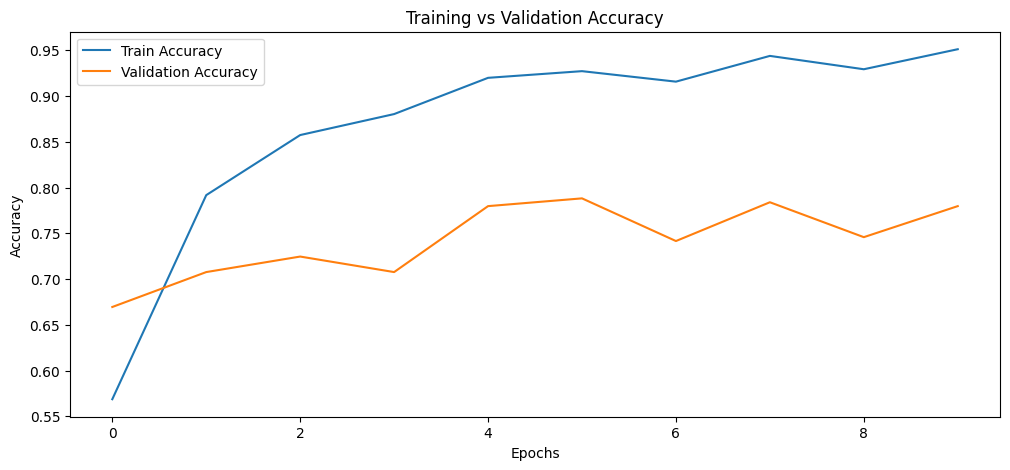

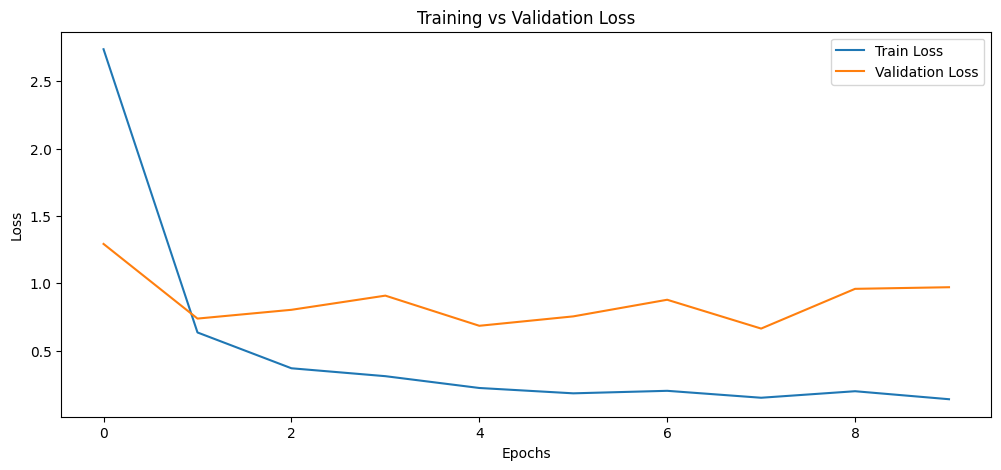

In [41]:
# Plot Accuracy
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Step 9: Evaluate Model**

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Confusion Matrix
[[ 4  5  1  3  1  3  9  4]
 [ 4  1  2  3  2  2  3  8]
 [ 6  3  1  2  5  1  6  3]
 [ 4  2  4  3  4  3  5  3]
 [ 1  5  2  1  2  0  6  7]
 [ 4  3  2  0  1  2  3  5]
 [ 6  8  6  5  3  5  5  6]
 [ 4 11  2  2  1  5  7  6]]


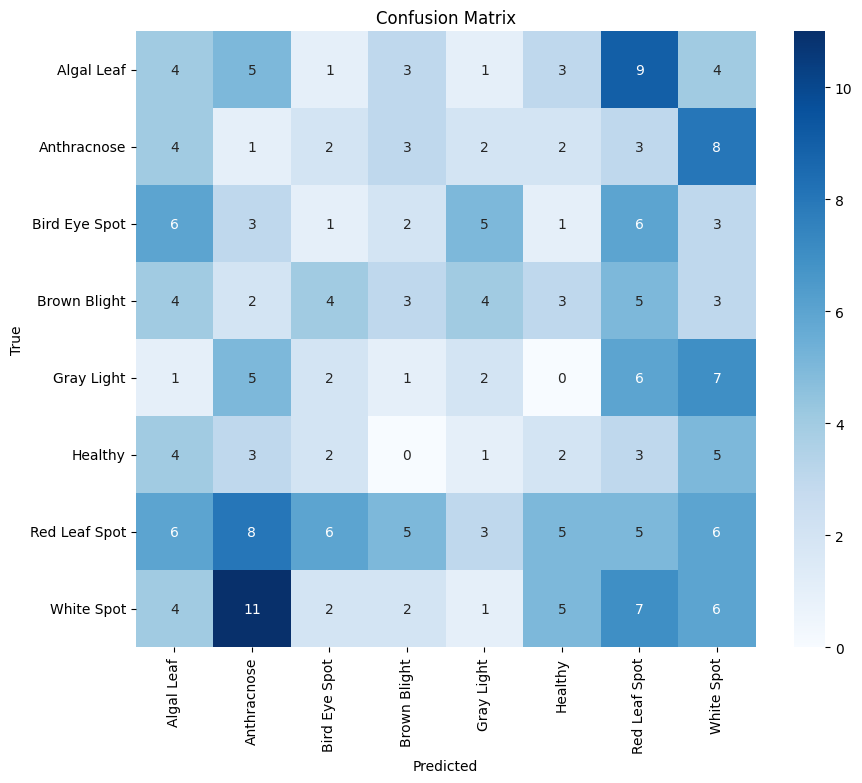

Classification Report
               precision    recall  f1-score   support

   Algal Leaf       0.12      0.13      0.13        30
  Anthracnose       0.03      0.04      0.03        25
Bird Eye Spot       0.05      0.04      0.04        27
 Brown Blight       0.16      0.11      0.13        28
   Gray Light       0.11      0.08      0.09        24
      Healthy       0.10      0.10      0.10        20
Red Leaf Spot       0.11      0.11      0.11        44
   White Spot       0.14      0.16      0.15        38

     accuracy                           0.10       236
    macro avg       0.10      0.10      0.10       236
 weighted avg       0.11      0.10      0.10       236



In [42]:
# Get predictions
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred), annot=True, fmt='d', xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


**Step 10: Save Model**

In [43]:
model.save('resnet50_tea_leaf_model.h5')


In [44]:
val_loss, val_acc = model_resnet.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7779 - loss: 0.8346
Validation Accuracy: 77.12%
Validation Loss: 0.7876
